In [1]:
import pandas as pd
import glob
from tqdm.notebook import tqdm

# if * in `task`, first load each task, and then combine

def loadMultipleTask(exp, task, keepModel=False, verbose=True):
    
    tasks = set()
    for file in glob.glob(f'./{exp}/*/{task}/*.csv'):
        
        # print(file)
        
        tasks.add(file.split('/')[-2])
        
    if verbose: print(tasks)
    
    res = {}
    for task in tqdm(tasks):
        dfs = loadExperimentTask(exp, task, keepModel=keepModel, verbose=False)
        
        for key, df in dfs.items():
            
            if key not in res:
                res[key] = df.dropna(how='all',axis=1)
            else:
                res[key] = pd.concat([res[key], df.dropna(how='all',axis=1)], ignore_index=True, sort=False)
                
    for key, df in res.items():
        if verbose: print(key, df.shape)
                
    return res

def loadExperimentTask(exp, task, keepModel=False, verbose=True):
    
    def biasedVote(row, bias=1.2):
        score = - row['mistake_score'] * bias + row['correct_score']
        if score < 0:
            return row['mistake']
        if score > 0:
            return row['correct']
        if score==0:
            return row['classify']
        
    mergedDf = {}
    
    for file in glob.glob(f'./{exp}/*/{task}/*.csv'):
        
        
        if keepModel:
            params = file.split('/')[-3]
        else:
            params = '_'.join(file.split('/')[-3].split('__')[-5:])
            
        mode = file.split('/')[-1].split('.')[0]
        
        df = pd.read_csv(
            file, index_col=0, dtype={
                'classify':str, 'label':str, 'correct':str, 'vote': str, 'mistake': str, 'single': str}
        ).assign(Task=task)
        
            
        if params not in mergedDf:
            mergedDf[params] = None
            
        
        if mergedDf[params] is None:
            mergedDf[params] = df.rename(columns={'score':mode+'_score'})
        else:
            mergedDf[params] = (
                mergedDf[params].merge(
                    df.rename(columns={'score':mode+'_score'}), on=['idx','label','Task'], how='outer'
                )
            )
        
    if verbose:
        for key, df in mergedDf.items():
            print(key, df.shape)
        
    return mergedDf

In [2]:
def emptyLine(func):
    
    def wrapper(*args, **kwargs):
        
        res = func(*args, **kwargs)
        
        if kwargs['verbose']==True: print()
        return res
        
    return wrapper
    
@emptyLine
def calcAccuracy(df, col=['correct','mistake','vote','single','array'], verbose=True):
    
    if verbose: print('Accuracy')
    
    accu = {}
    
    try:
        accuracy = (df['classify'] == df['label']).value_counts(normalize=True)[True]
    except KeyError as e:
        print(e)
        accuracy = 0
        
    if verbose: print(f'clas {accuracy:.5f}')
    accu['classify'] = accuracy
    
    for mode in col:
        try:
            accuracy = (df[mode] == df['label']).value_counts(normalize=True)[True]
        except KeyError as e:
            accuracy = 0
        
        if verbose: print(f'{mode} {accuracy:.5f} (out of {df.shape[0]})')
        accu[mode] = accuracy
            
    return accu
        

def fillInNA(df, col=['correct','mistake','vote','single','array']):
    
    for ind, row in df.iterrows():
        for m in col:
                
            if m not in df.columns or pd.isna(df.at[ind, m]):
                if 'classify' in df.columns:
                    df.at[ind, m] = df.at[ind, 'classify']
                
    return df

def countSingleFlip(df, mode, compareWith='classify', equal=False):
    try:
        df = df[[mode,compareWith]].dropna()
        if df.shape[0]==0:
            return
        print(mode, round((df[mode] == df[compareWith]).value_counts(normalize=True)[equal]*100, 1))
    except KeyError as e:
        print(mode, 0)

@emptyLine
def countFlip(df, col=['correct','mistake','vote','single','array'],
              compareWith='classify', equal=False, verbose=True):
    
    for mode in col:
        countSingleFlip(df, mode, compareWith=compareWith, equal=equal)

In [3]:
def parseNumber(x):
    if type(x) == float or type(x) == int:
        return x
    
    x = x.replace(',','')
    
    try:
        x = float(x)
        
        if int(x) == x:
            return int(x)
        else:
            return x
        
    except Exception as e:
        return pd.NA

## Results with biased prompts

In [4]:
df = loadMultipleTask('res_exp_biased', "mmlu1000-*", verbose=False)
cols=[f'experiment-{x}' for x in [0, 1, 6, 7, 8, 9, 10, 11]]

for key, f in df.items():
    
    f = fillInNA(f, col=cols)
    
    res = calcAccuracy(f, col=cols, verbose=True)
    res['Param'] = key
    
    print('% changes when the original answer was correct (false positive rate):')
    countFlip(f.query('classify==label'), col=cols, verbose=True)

  0%|          | 0/57 [00:00<?, ?it/s]

Accuracy
clas 0.64400
experiment-0 0.57800 (out of 1000)
experiment-1 0.63500 (out of 1000)
experiment-6 0.47400 (out of 1000)
experiment-7 0.53600 (out of 1000)
experiment-8 0.55600 (out of 1000)
experiment-9 0.57500 (out of 1000)
experiment-10 0.54300 (out of 1000)
experiment-11 0.53200 (out of 1000)

% changes when the original answer was correct (false positive rate):
experiment-0 18.9
experiment-1 7.6
experiment-6 40.4
experiment-7 29.8
experiment-8 23.4
experiment-9 21.3
experiment-10 27.3
experiment-11 32.5



In [5]:
acc = [57.8, 63.5, 47.4, 53.6, 55.6, 57.5, 54.3, 53.2]
fpr = [18.9, 7.6, 40.4, 29.8, 23.4, 21.3, 27.3, 32.5]

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['axes.linewidth'] = 0.5
plt.rcParams["font.size"] = 7

cm = 1/2.54  # centimeters in inches

In [7]:
r = pearsonr(fpr, acc)

Text(8, 50, '$r = -0.99$, $p = 3.0e-06$')

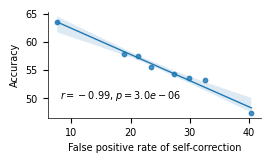

In [8]:
plt.figure(figsize=(7*cm, 3.5*cm))

ax = sns.regplot(x=fpr, y=acc, scatter_kws={'s': 10}, line_kws={'linewidth': 1})

ax.spines[['top','right']].set_visible(False)
ax.set_xlabel('False positive rate of self-correction')
ax.set_ylabel('Accuracy')

ax.text(x=8, y=50, s=f'$r = {r.statistic:.2f}$, $p = {r.pvalue:.1e}$')

# plt.savefig('./figures/correlation.pdf', bbox_inches = 'tight', pad_inches = 0)

# Results of MoP

## Results with mmlu1000

In [9]:
%%time
df = loadMultipleTask('results', "mmlu1000-*", keepModel=True, verbose=False)

for key, f in df.items():
    
    if key != 'meta-llama__Meta-Llama-3-8B-Instruct__True__1__0.4__10__0.7': continue
    
    f = fillInNA(f, col=['correct','mistake','vote','single','array'])
    
    calcAccuracy(f, col=['correct','mistake','vote','single','array'], verbose=True)
    
    print('Percentage changed when the original answer was correct (false positive rate):')
    countFlip(f.query('classify==label'), verbose=True, equal=False)
    # equal=False means that reflected answer is different from initial answer
    
    print('Percentage unchanged when the original answer was wrong (false negative rate):')
    countFlip(f.query('classify!=label'), verbose=True, equal=True)
    # equal=True means that the reflected answer is same as initial answer

  0%|          | 0/57 [00:00<?, ?it/s]

Accuracy
clas 0.64100
correct 0.65000 (out of 1000)
mistake 0.59900 (out of 1000)
vote 0.65100 (out of 1000)
single 0.65200 (out of 1000)
array 0.61500 (out of 1000)

Percentage changed when the original answer was correct (false positive rate):
correct 0.3
mistake 17.0
vote 0.9
single 1.2
array 5.3

Percentage unchanged when the original answer was wrong (false negative rate):
correct 95.7
mistake 62.7
vote 94.9
single 91.7
array 94.9

CPU times: user 7 s, sys: 507 ms, total: 7.51 s
Wall time: 8.14 s


## GSM8K

In [10]:
%%time
df = loadMultipleTask('results', "gsm8k-*", keepModel=True, verbose=False)

for key, f in df.items():
    
    if key != 'meta-llama__Meta-Llama-3-8B-Instruct__True__1__0.4__10__0.7': continue
    
    f = (
        f
        .assign(label=lambda df: df.label.apply(parseNumber))
        .assign(classify=lambda df: df.classify.apply(parseNumber))
        .assign(correct=lambda df: df.correct.apply(parseNumber))
        .assign(mistake=lambda df: df.mistake.apply(parseNumber))
        .assign(vote=lambda df: df.vote.apply(parseNumber))
        .assign(single=lambda df: df.single.apply(parseNumber))
        .assign(array=lambda df: df.array.apply(parseNumber))
    )
    
    f = fillInNA(f, col=['correct','mistake','vote','single', 'array'])
    
    calcAccuracy(f, col=['correct','mistake','vote','single', 'array'], verbose=True)
    
    print('Percentage changed when the original answer was correct (false positive rate):')
    countFlip(f.query('classify==label'), verbose=True, equal=False)
    # equal=False means that reflected answer is different from initial answer
    
    print('Percentage unchanged when the original answer was wrong (false negative rate):')
    countFlip(f.query('classify!=label'), verbose=True, equal=True)
    # equal=True means that the reflected answer is same as initial answer

  0%|          | 0/8 [00:00<?, ?it/s]

Accuracy
clas 0.82487
correct 0.82638 (out of 1319)
mistake 0.64291 (out of 1319)
vote 0.82335 (out of 1319)
single 0.81274 (out of 1319)
array 0.66566 (out of 1319)

Percentage changed when the original answer was correct (false positive rate):
correct 1.4
mistake 24.6
vote 1.9
single 3.1
array 20.1

Percentage unchanged when the original answer was wrong (false negative rate):
correct 95.0
mistake 60.3
vote 93.5
single 90.5
array 75.9

CPU times: user 733 ms, sys: 25.9 ms, total: 759 ms
Wall time: 816 ms


## CommonSenseQA

In [11]:
%%time
df = loadMultipleTask('results', "csqa-*", keepModel=True, verbose=False)

for key, f in df.items():
    
    if key != 'meta-llama__Meta-Llama-3-8B-Instruct__True__1__0.4__10__0.7': continue
    
    f = fillInNA(f, col=['correct','mistake','vote','single','array'])
    
    calcAccuracy(f, col=['correct','mistake','vote','single','array'], verbose=True)
    
    print('Percentage changed when the original answer was correct (false positive rate):')
    countFlip(f.query('classify==label'), verbose=True, equal=False)
    # equal=False means that reflected answer is different from initial answer
    
    print('Percentage unchanged when the original answer was wrong (false negative rate):')
    countFlip(f.query('classify!=label'), verbose=True, equal=True)
    # equal=True means that the reflected answer is same as initial answer

  0%|          | 0/9 [00:00<?, ?it/s]

Accuracy
clas 0.76085
correct 0.76167 (out of 1221)
mistake 0.71089 (out of 1221)
vote 0.76495 (out of 1221)
single 0.76331 (out of 1221)
array 0.75430 (out of 1221)

Percentage changed when the original answer was correct (false positive rate):
correct 0.3
mistake 12.7
vote 0.8
single 0.6
array 1.1

Percentage unchanged when the original answer was wrong (false negative rate):
correct 98.2
mistake 66.8
vote 94.1
single 95.9
array 97.0

CPU times: user 605 ms, sys: 22.7 ms, total: 627 ms
Wall time: 671 ms
